### Loading datasets

In [38]:
!pip install yfinance

In [39]:
import yfinance as yf
import pandas as pd

# Top 10 companies by market cap for the 28-03-2025
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOG", "2222.SR", "META", "BRK-B", "TSLA", "TSM"]

historical_data = {}

for ticker in tickers:
  data = yf.Ticker(ticker)
  historical_data[ticker] = data.history(period="10y")

historical_data

{'AAPL':                                  Open        High         Low       Close  \
 Date                                                                        
 2015-03-30 00:00:00-04:00   27.703802   28.228621   27.692635   28.221922   
 2015-03-31 00:00:00-04:00   28.159389   28.248720   27.773033   27.788666   
 2015-04-01 00:00:00-04:00   27.875759   27.942758   27.491636   27.748463   
 2015-04-02 00:00:00-04:00   27.922662   28.041025   27.735067   27.987427   
 2015-04-06 00:00:00-04:00   27.797601   28.476518   27.766335   28.440784   
 ...                               ...         ...         ...         ...   
 2025-03-24 00:00:00-04:00  221.000000  221.479996  218.580002  220.729996   
 2025-03-25 00:00:00-04:00  220.770004  224.100006  220.080002  223.750000   
 2025-03-26 00:00:00-04:00  223.509995  225.020004  220.470001  221.529999   
 2025-03-27 00:00:00-04:00  221.389999  224.990005  220.559998  223.850006   
 2025-03-28 00:00:00-04:00  221.649002  223.800003  219.

In [40]:
# Formatting index column into year-month-day, removing smaller timeframe data
def format_date(df):
  df.index = pd.to_datetime(df.index)
  df.index = df.index.strftime('%Y-%m-%d')

for ticker, df in historical_data.items():
  format_date(df)

historical_data["AAPL"].index


Index(['2015-03-30', '2015-03-31', '2015-04-01', '2015-04-02', '2015-04-06',
       '2015-04-07', '2015-04-08', '2015-04-09', '2015-04-10', '2015-04-13',
       ...
       '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21',
       '2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28'],
      dtype='object', name='Date', length=2516)

### Implementation of the Moving-Averages-Crossover strategy

Hyperparamteres for the strategy configuration

In [41]:
parameter_grid = {
    "shortterm_window": list(range(40, 61, 5)),
    "longterm_window": list(range(180, 221, 10)),
    "lag": list(range(0, 6))
}

In [42]:
import numpy as np
import pandas as pd

initial_cash = 10_000  # Initial capital, you can change it accordingly

best_parameters = {}

for ticker, df in historical_data.items():
    best_return = -np.inf
    best_sharpe = -np.inf
    best_params = {}

    for shortterm_window in parameter_grid["shortterm_window"]:
        for longterm_window in parameter_grid["longterm_window"]:
            # Skip invalid combinations
            if shortterm_window >= longterm_window:
                continue

            for lag in parameter_grid["lag"]:
                data = df.copy().dropna()

                data["shortterm_ma"] = data["Close"].rolling(shortterm_window).mean()
                data["longterm_ma"] = data["Close"].rolling(longterm_window).mean()

                # Create signals
                data['signal'] = 0
                data.loc[data['shortterm_ma'] > data['longterm_ma'], 'signal'] = 1
                data.loc[data['shortterm_ma'] < data['longterm_ma'], 'signal'] = -1
                data['signal'] = data['signal'].shift(lag).fillna(0)

                # Returns clearly formatted as percentages (e.g., 2.0%)
                data['return'] = data['Close'].pct_change() * 100
                data['strategy_return'] = data['return'] * data['signal'].shift(1)

                # Convert percentage returns to growth factors for cumulative return
                cumulative_return = (1 + data['strategy_return'] / 100).cumprod().iloc[-1] - 1

                sharpe_ratio = (
                    data['strategy_return'].mean() / data['strategy_return'].std()
                ) * np.sqrt(252)

                # Initial and final cash calculations
                final_cash = initial_cash * (1 + cumulative_return)

                # Check if this combination is best so far
                if cumulative_return > best_return:
                    best_return = cumulative_return
                    best_sharpe = sharpe_ratio
                    best_params = {
                        'shortterm_window': shortterm_window,
                        'longterm_window': longterm_window,
                        'lag': lag,
                        'total_return_%': round(cumulative_return * 100, 2),
                        'sharpe_ratio': round(sharpe_ratio, 2),
                        'initial_cash': initial_cash,
                        'final_cash': round(final_cash, 2)
                    }

    best_parameters[ticker] = best_params

# Convert best parameters into DataFrame clearly
results_df = pd.DataFrame.from_dict(best_parameters, orient='index')
print(results_df)

         shortterm_window  longterm_window  lag  total_return_%  sharpe_ratio  \
AAPL                   60              180    3          250.89          0.59   
MSFT                   40              220    0         1018.49          1.07   
NVDA                   50              180    2        48583.15          1.52   
AMZN                   40              220    0          465.72          0.72   
GOOG                   60              220    1          270.46          0.62   
2222.SR                40              220    5           20.54          0.33   
META                   40              200    1          265.58          0.54   
BRK-B                  45              180    2           70.60          0.38   
TSLA                   60              180    1          112.11          0.42   
TSM                    40              200    1          487.06          0.72   

         initial_cash  final_cash  
AAPL            10000    35089.33  
MSFT            10000   111848.69  


### Visualization of Buy and Sell orders

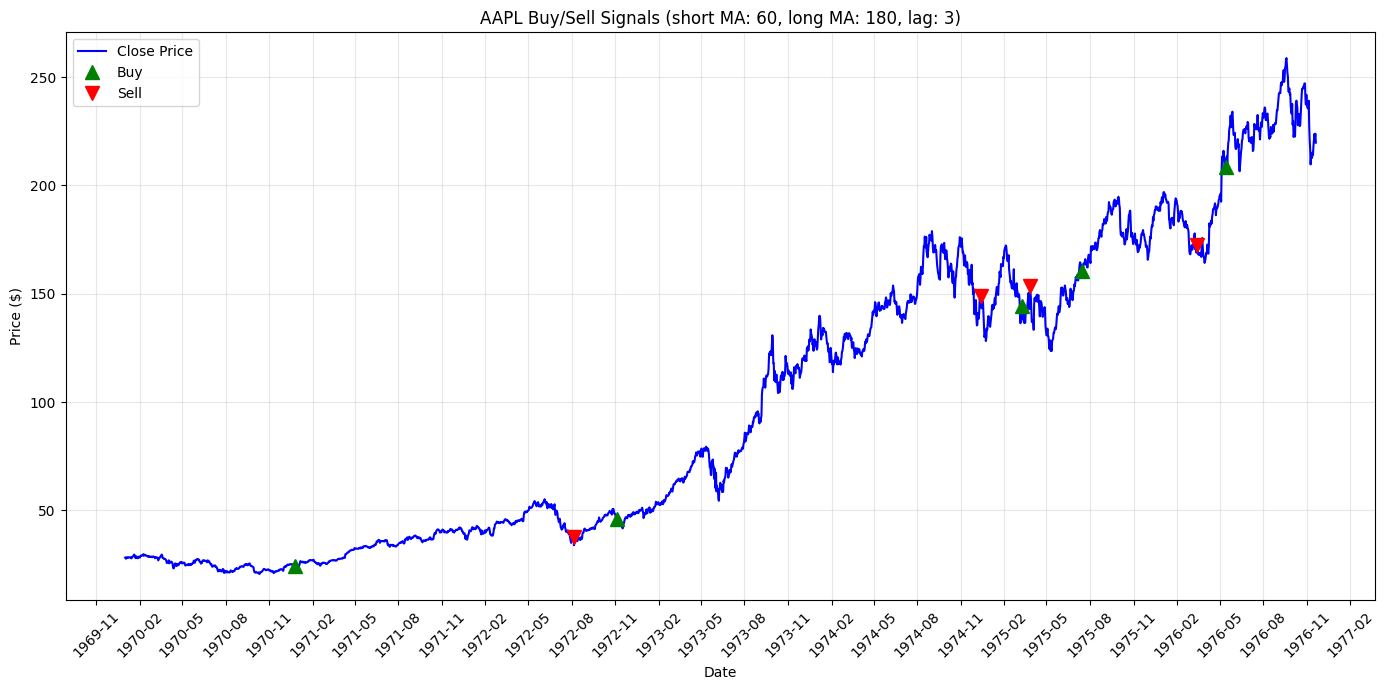

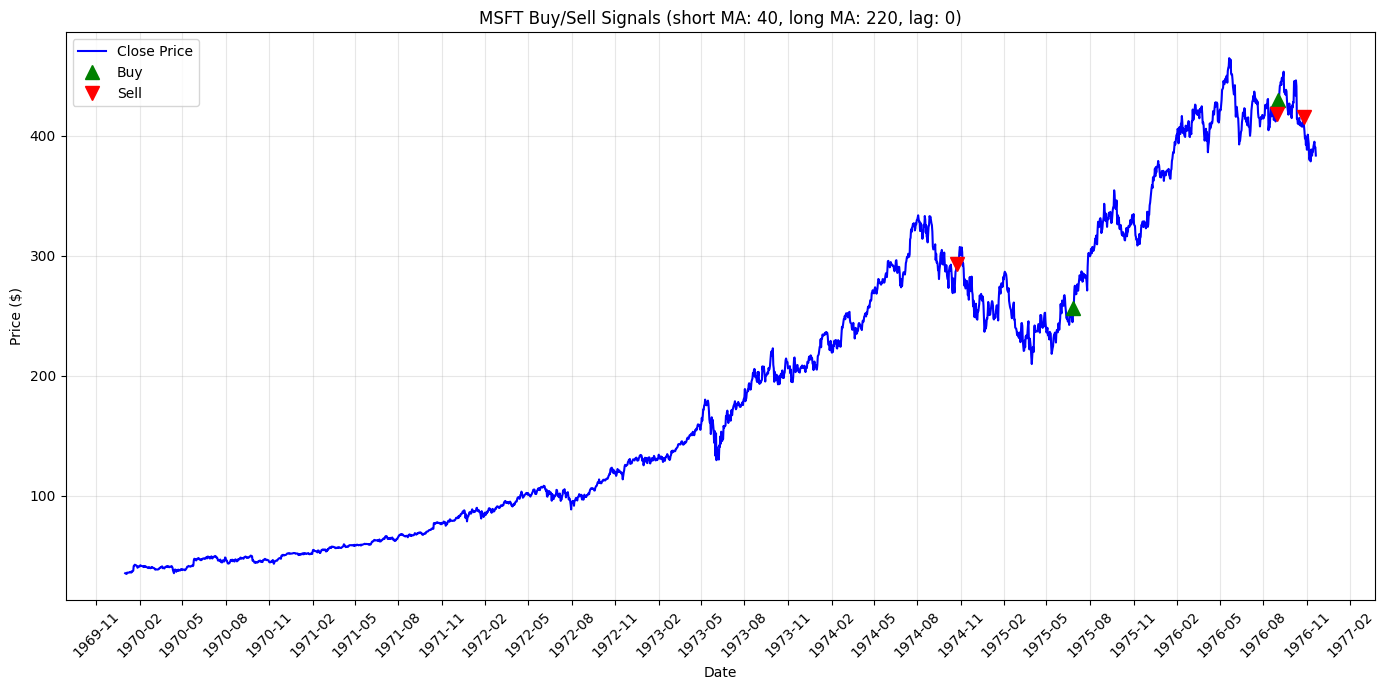

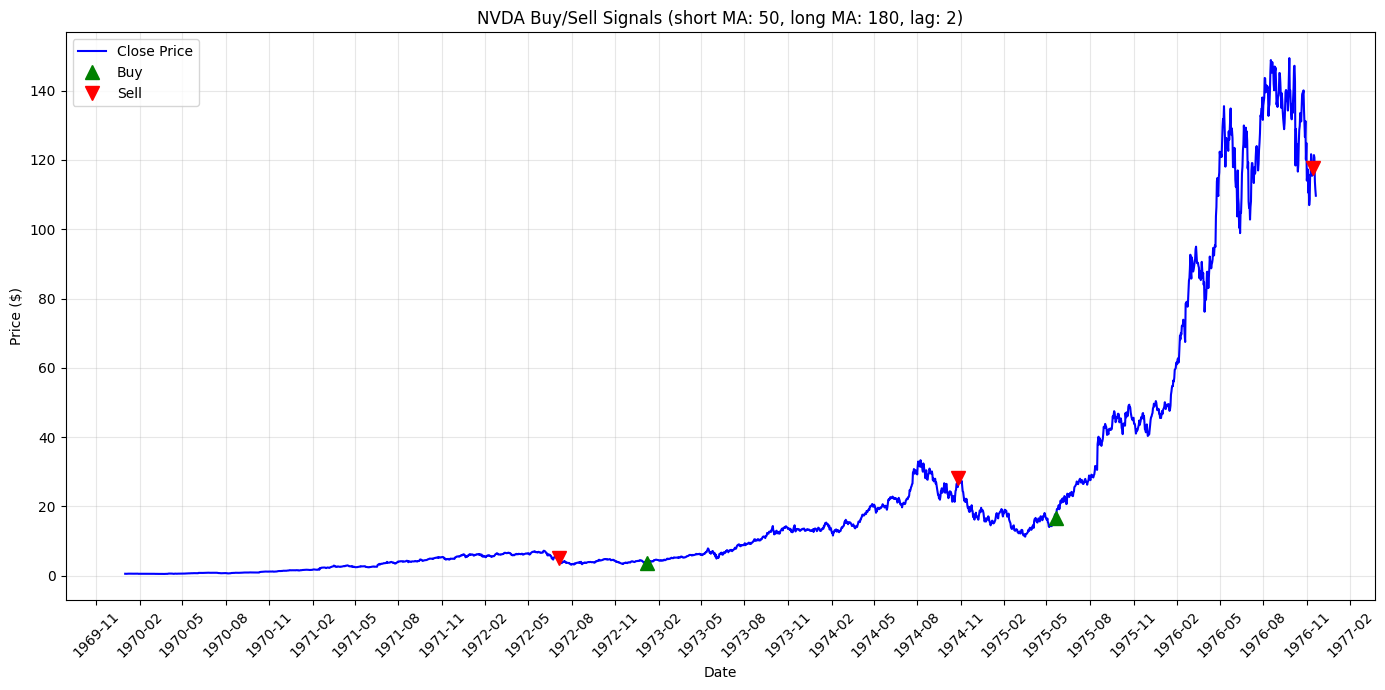

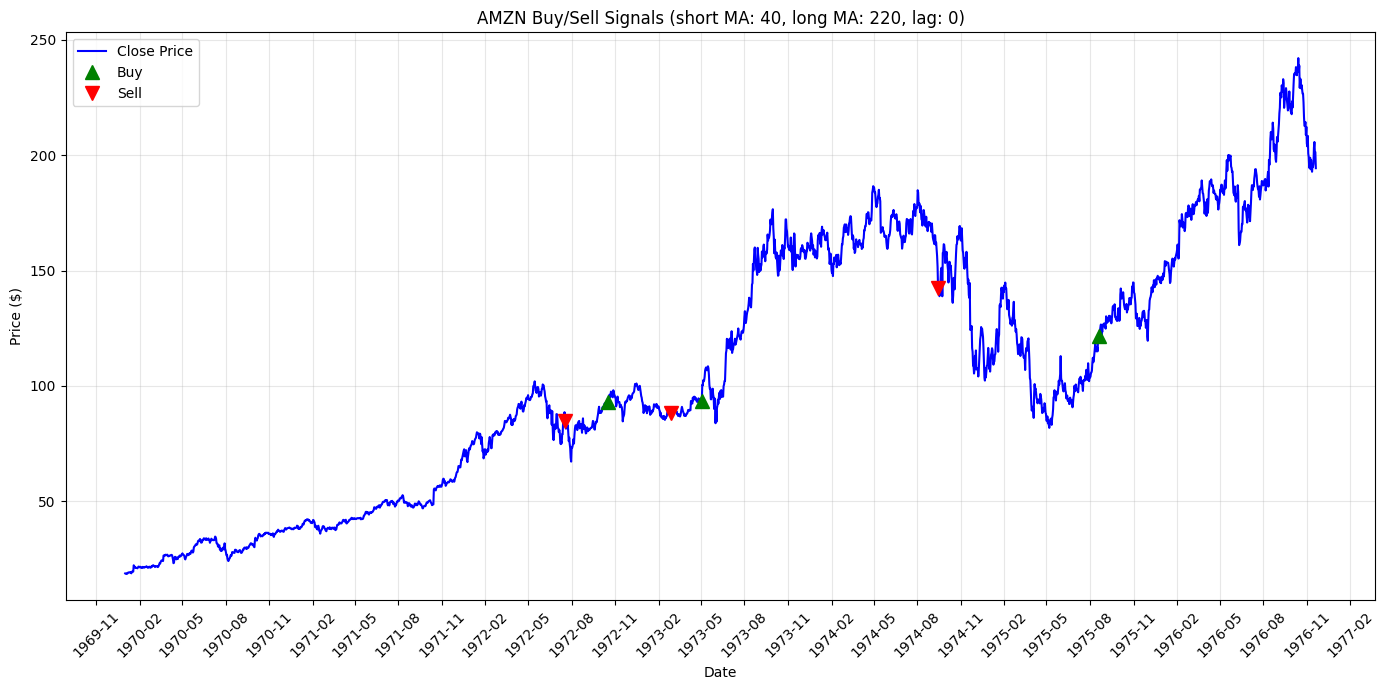

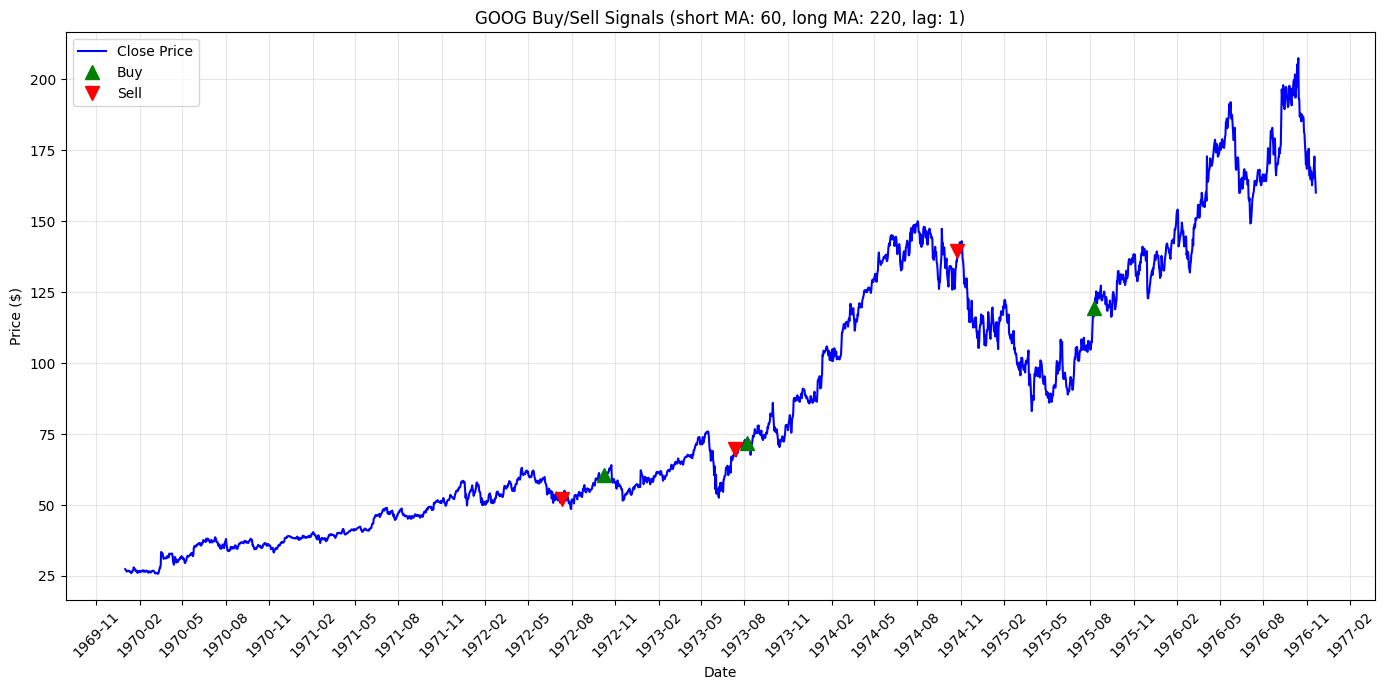

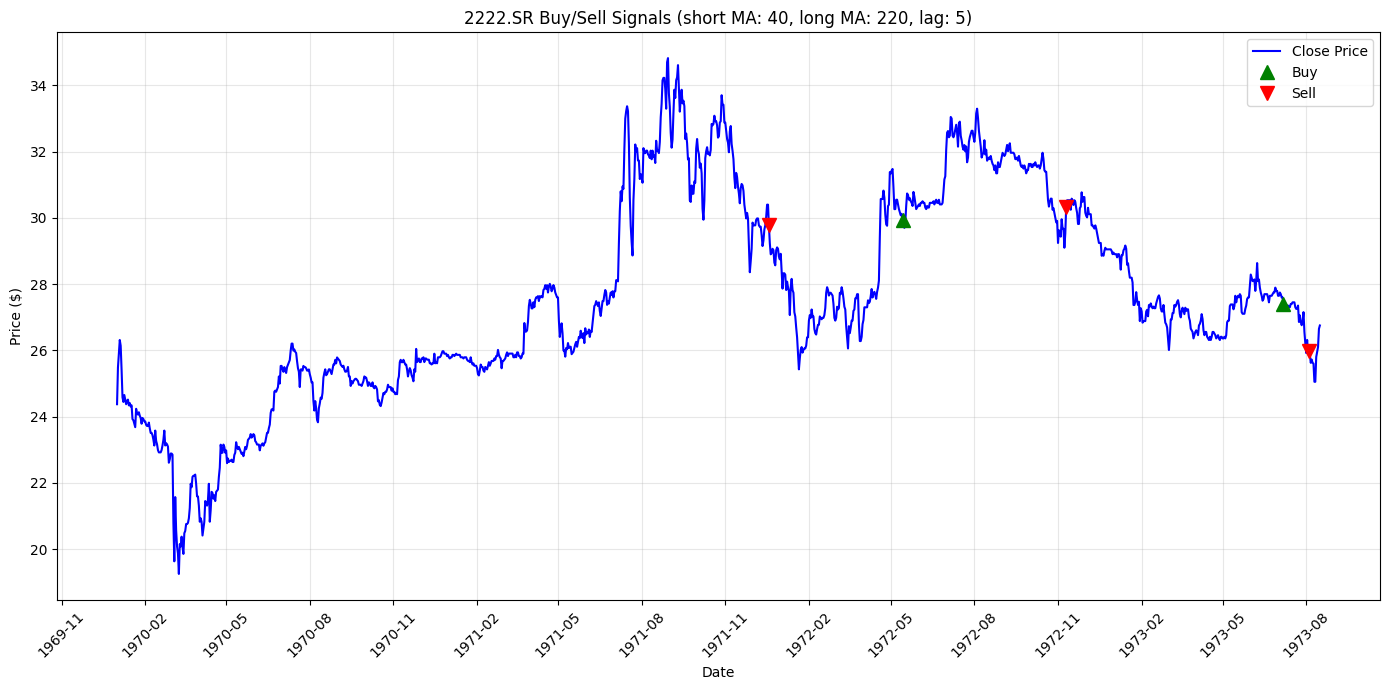

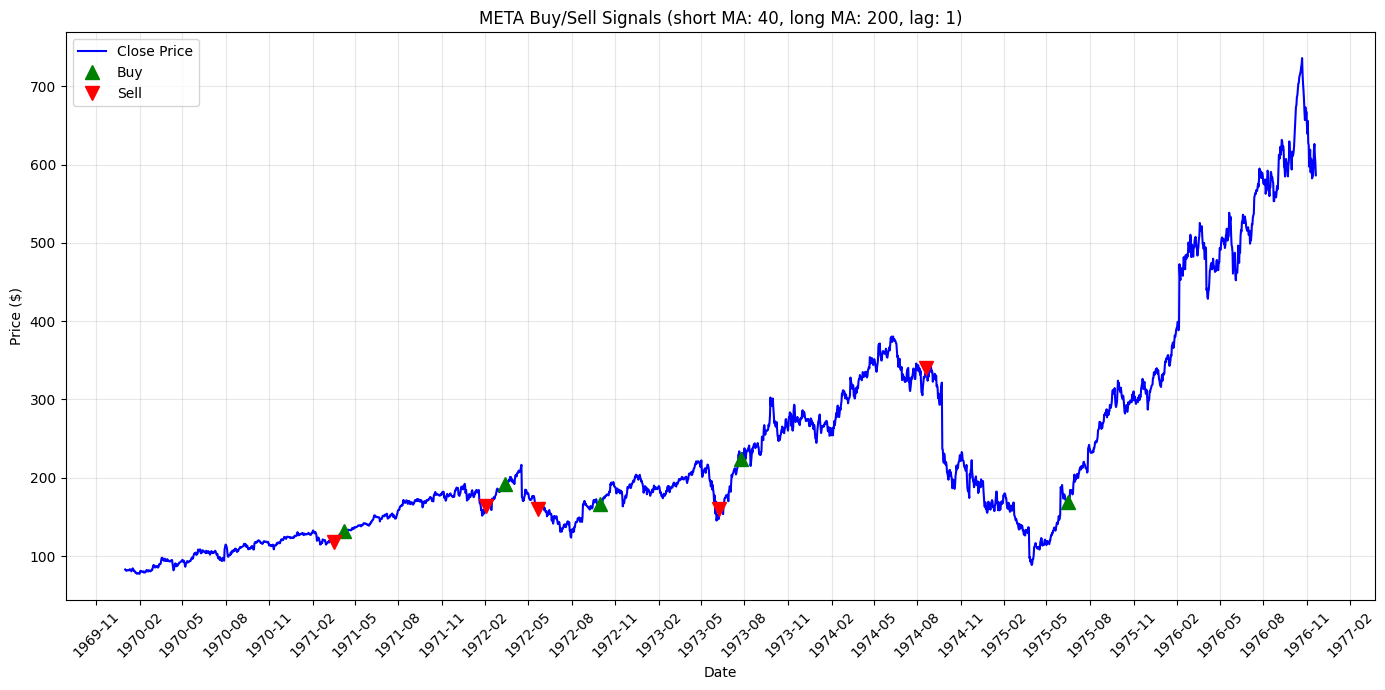

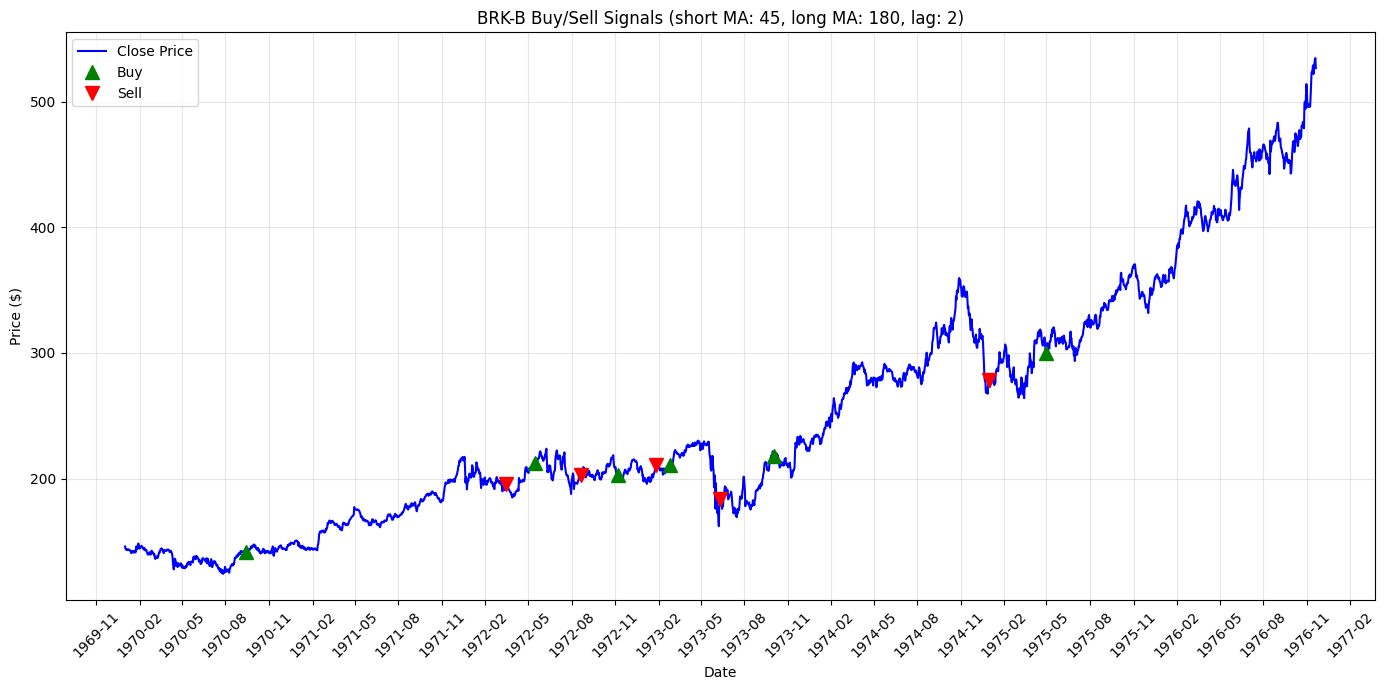

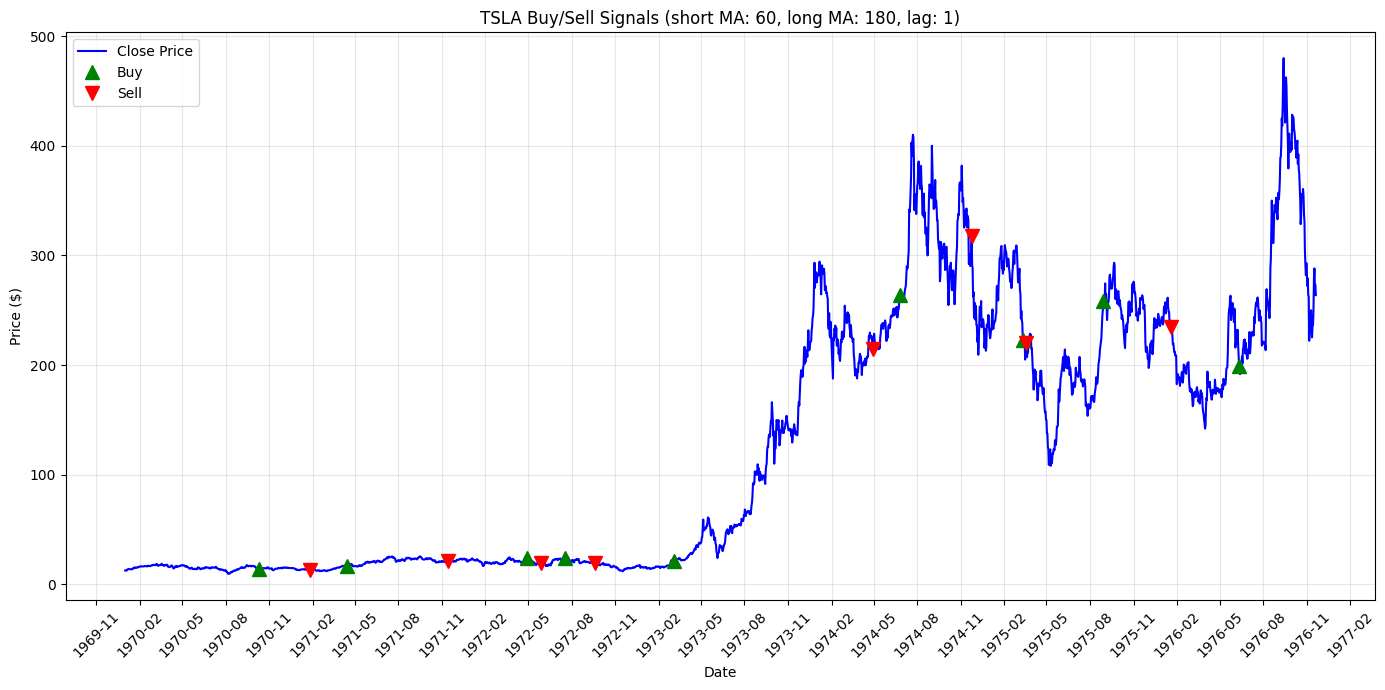

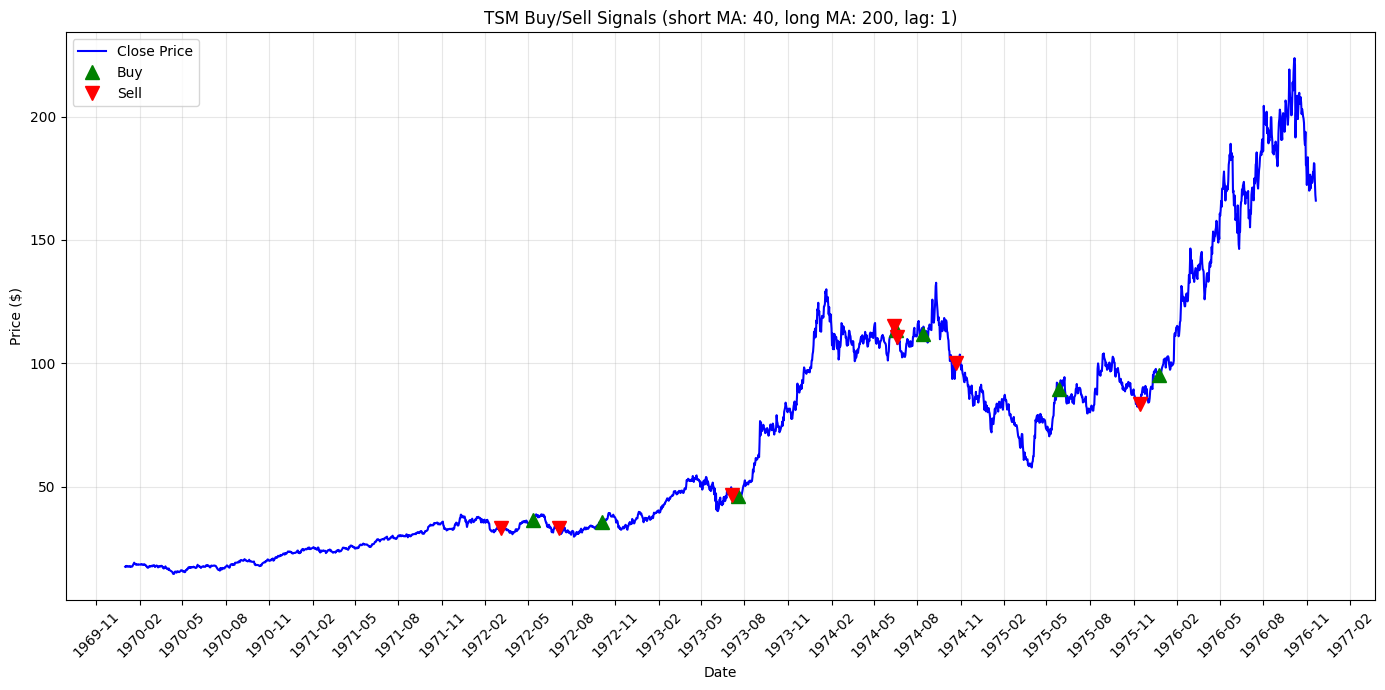

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

initial_cash = 10_000

for ticker, params in best_parameters.items():
    df = historical_data[ticker].copy().dropna()

    shortterm_window = params['shortterm_window']
    longterm_window = params['longterm_window']
    lag = params['lag']

    # Compute exponential moving averages
    df["shortterm_ma"] = df["Close"].rolling(shortterm_window).mean()
    df["longterm_ma"] = df["Close"].rolling(longterm_window).mean()

    # Signals
    df['signal'] = 0
    df.loc[df['shortterm_ma'] > df['longterm_ma'], 'signal'] = 1
    df.loc[df['shortterm_ma'] < df['longterm_ma'], 'signal'] = -1
    df['signal'] = df['signal'].shift(lag).fillna(0)

    # Identify buy/sell orders clearly
    df['positions'] = df['signal'].diff()

    # Plot price data
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label="Close Price", linewidth=1.5, color='blue')

    # Plot buy signals
    plt.plot(df[df['positions'] == 2].index,
             df['Close'][df['positions'] == 2],
             '^', markersize=10, color='green', label='Buy')

    # Plot sell signals
    plt.plot(df[df['positions'] == -2].index,
             df['Close'][df['positions'] == -2],
             'v', markersize=10, color='red', label='Sell')

    # Formatting the x-axis clearly
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.title(f"{ticker} Buy/Sell Signals (short MA: {shortterm_window}, long MA: {longterm_window}, lag: {lag})")
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### Comparison against Buy and Hold strategy

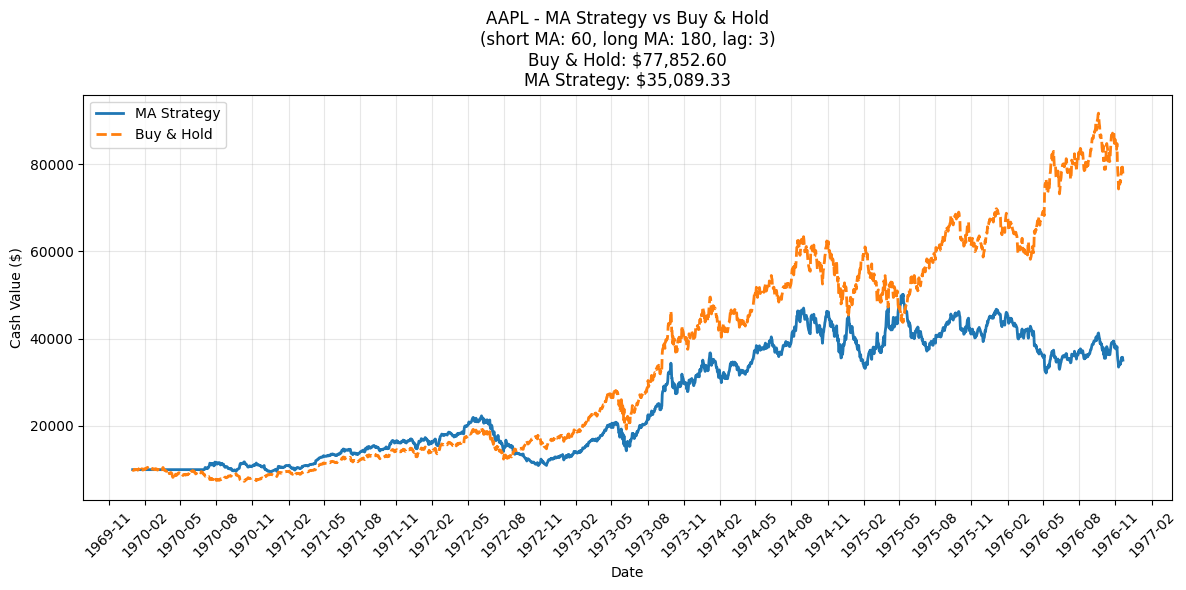

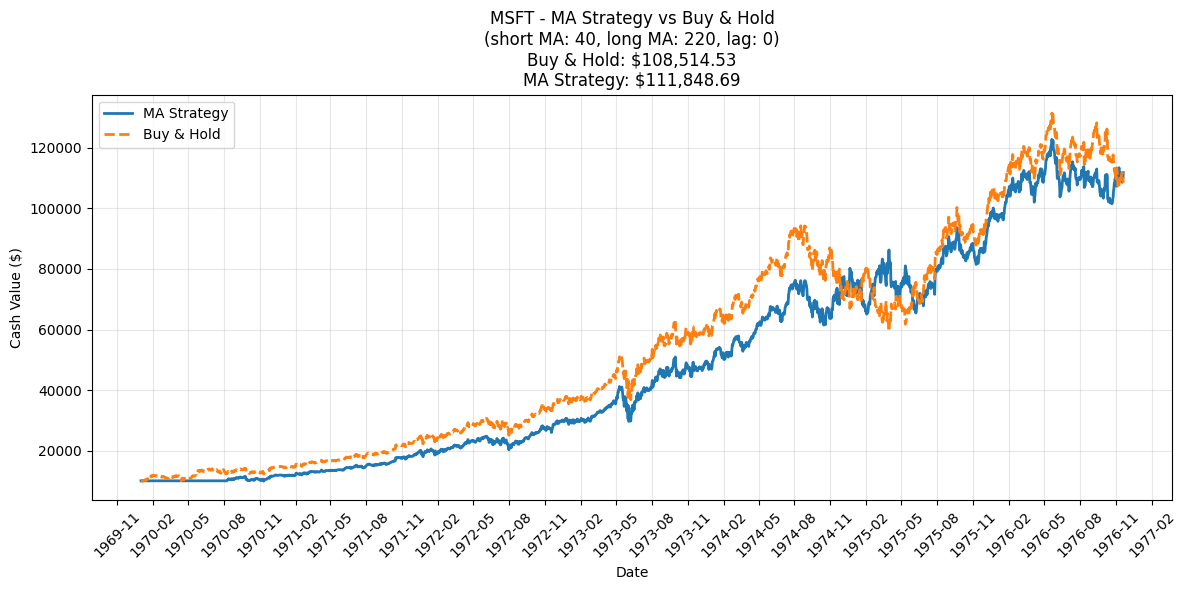

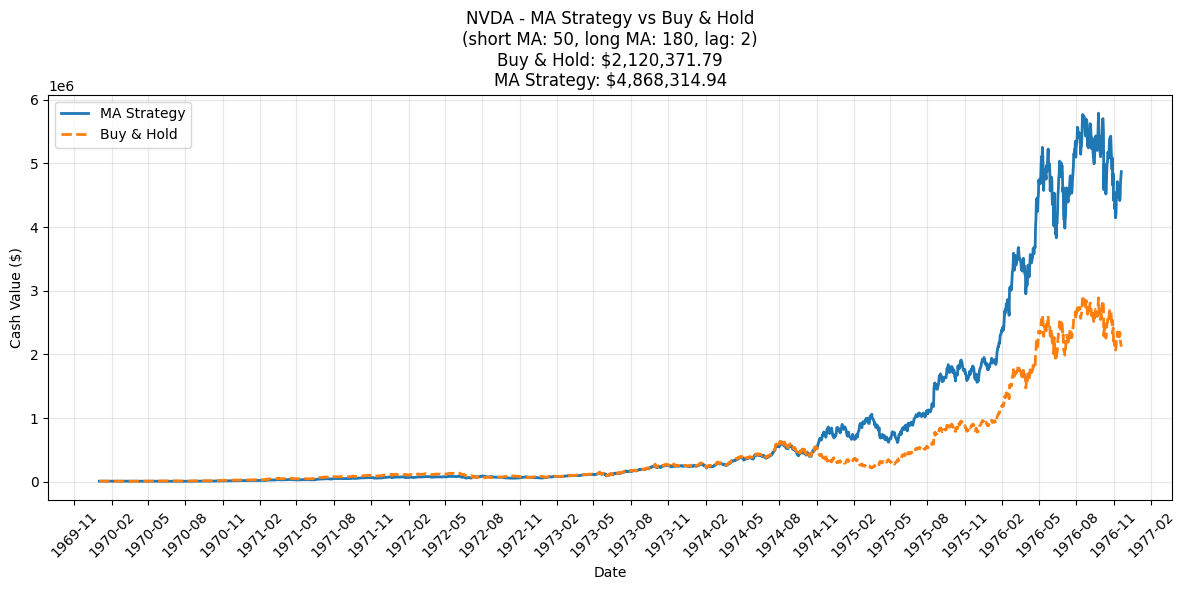

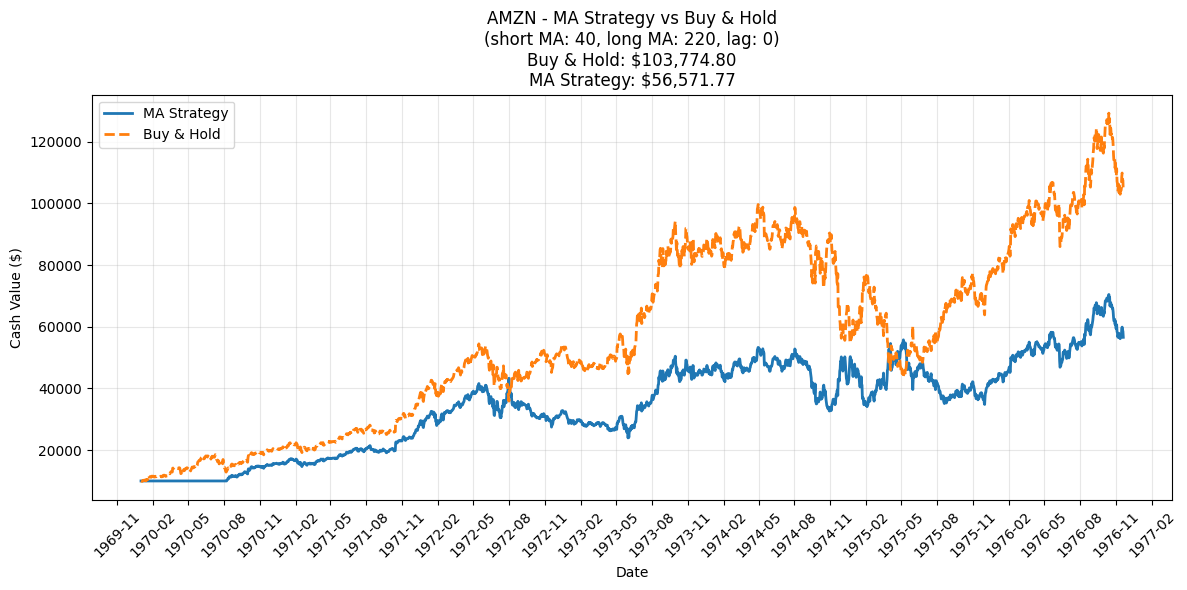

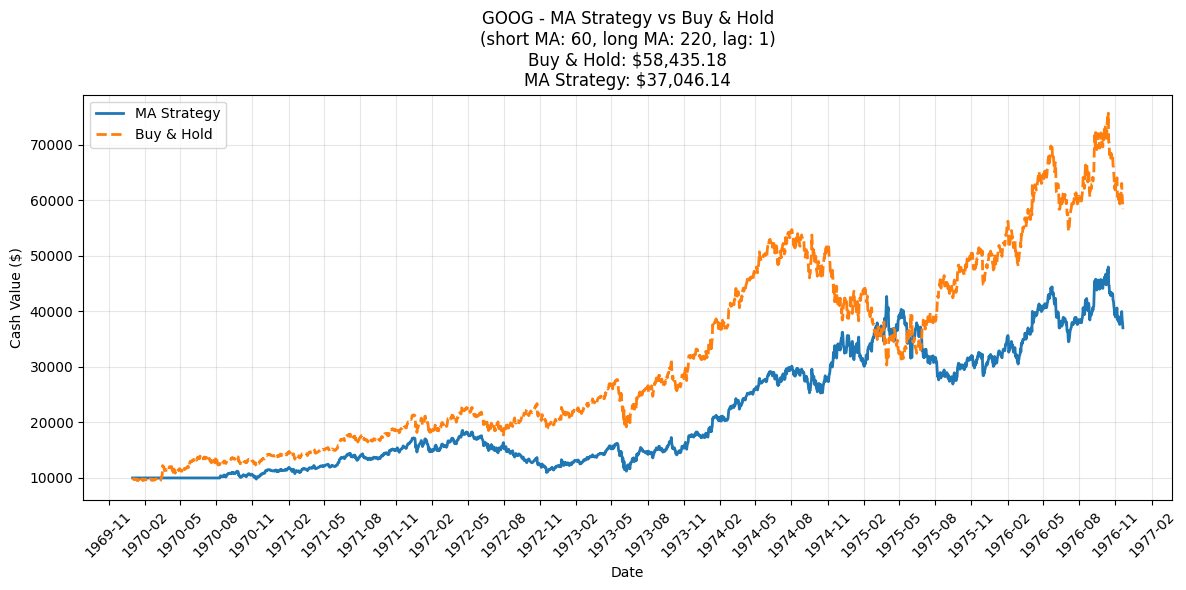

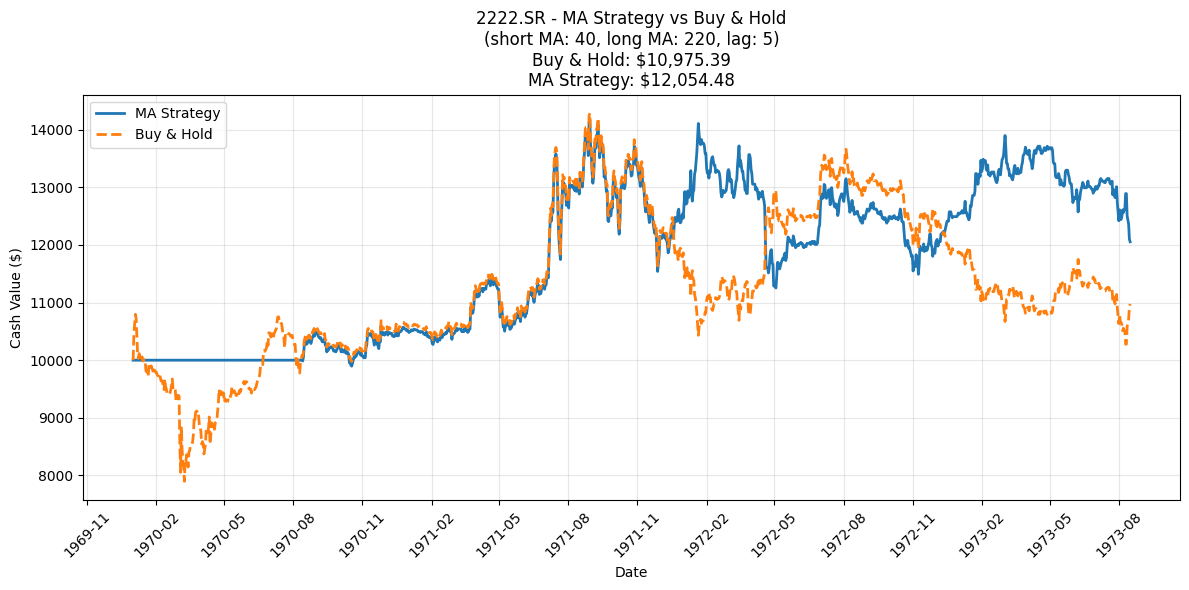

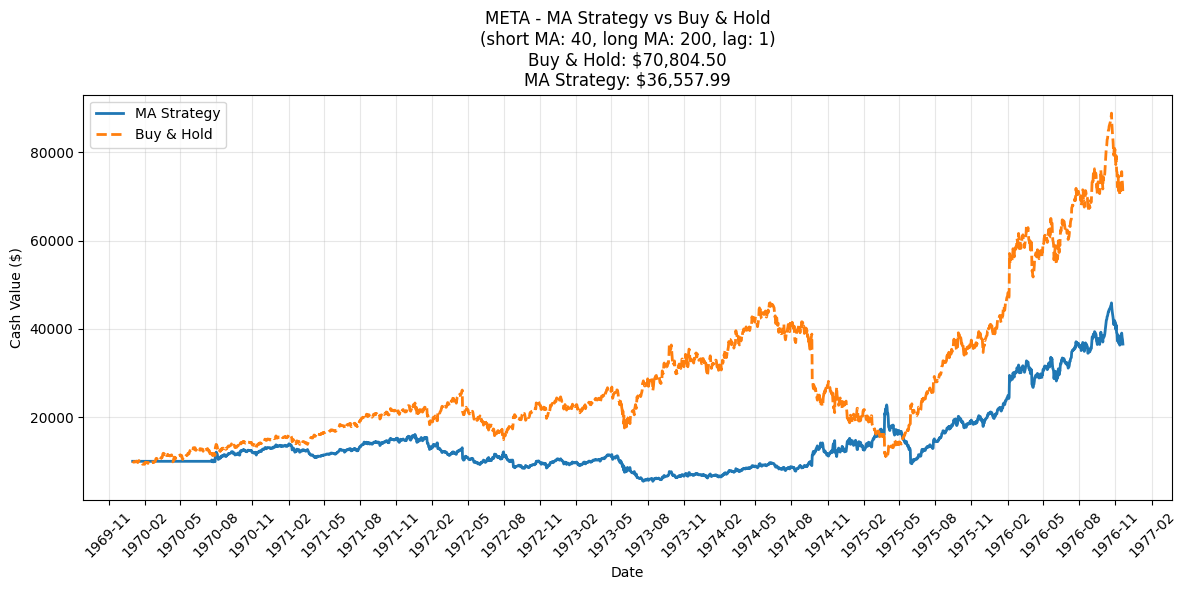

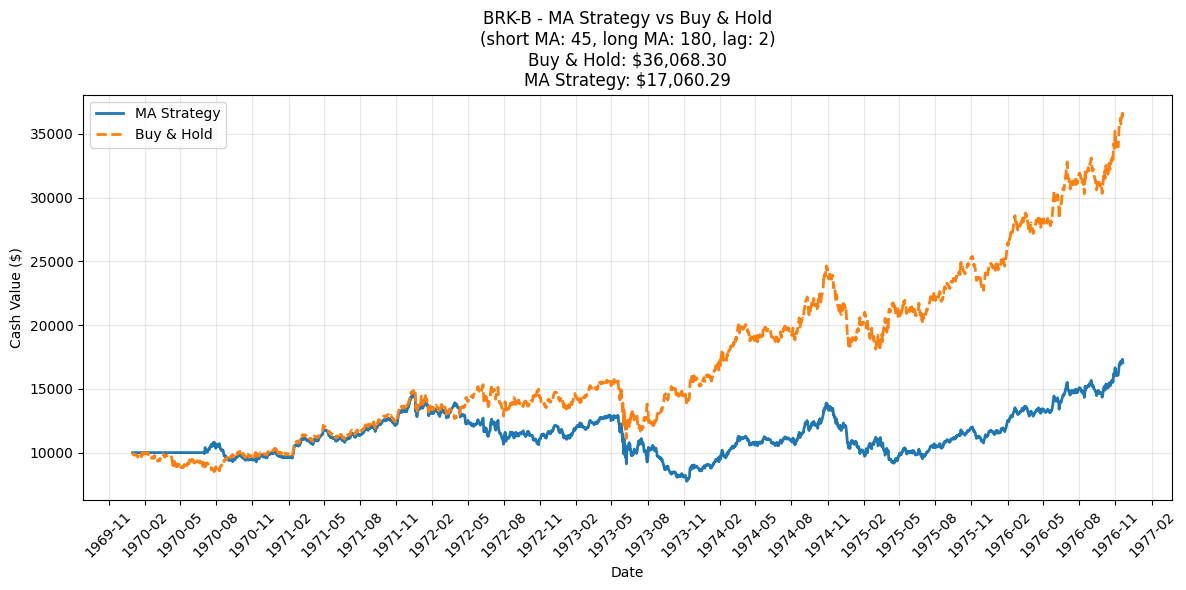

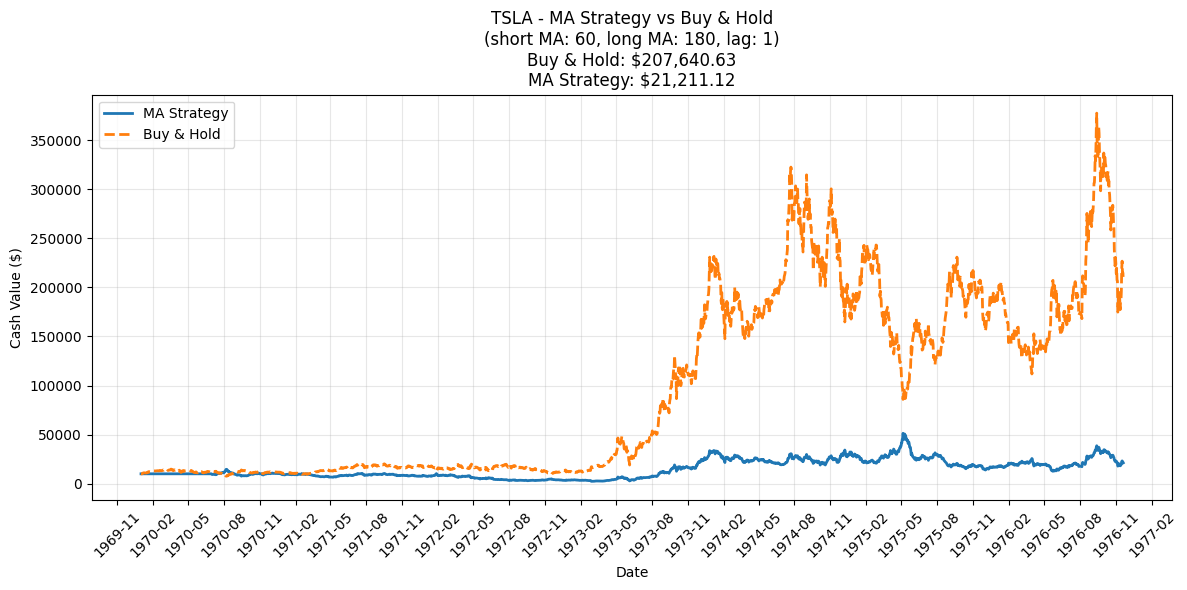

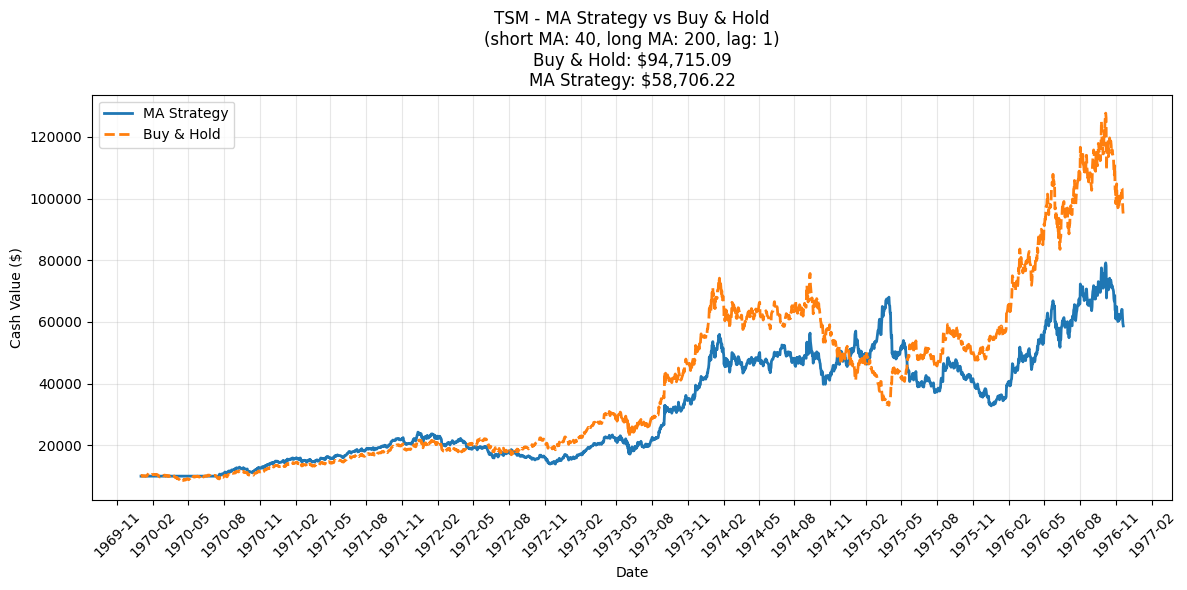

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

initial_cash = 10000

for ticker, params in best_parameters.items():
    df = historical_data[ticker].copy().dropna()

    shortterm_window = params['shortterm_window']
    longterm_window = params['longterm_window']
    lag = params['lag']

    df["shortterm_ma"] = df["Close"].rolling(shortterm_window).mean()
    df["longterm_ma"] = df["Close"].rolling(longterm_window).mean()

    df['signal'] = 0
    df.loc[df['shortterm_ma'] > df['longterm_ma'], 'signal'] = 1
    df.loc[df['shortterm_ma'] < df['longterm_ma'], 'signal'] = -1
    df['signal'] = df['signal'].shift(lag).fillna(0)

    df['market_return'] = df['Close'].pct_change()
    df['strategy_return'] = df['market_return'] * df['signal'].shift(1)

    df['strategy_cash'] = initial_cash * (1 + df['strategy_return'].fillna(0)).cumprod()
    df['buy_hold_cash'] = initial_cash * (1 + df['market_return'].fillna(0)).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['strategy_cash'], label="MA Strategy", linewidth=2)
    plt.plot(df.index, df['buy_hold_cash'], label="Buy & Hold", linewidth=2, linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.title(f"{ticker} - MA Strategy vs Buy & Hold\n"
          f"(short MA: {shortterm_window}, long MA: {longterm_window}, lag: {lag})\n"
          f"Buy & Hold: ${df['buy_hold_cash'].iloc[-1]:,.2f}\n"
          f"MA Strategy: ${df['strategy_cash'].iloc[-1]:,.2f}")
    plt.xlabel("Date")
    plt.ylabel("Cash Value ($)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()